# Topics Notebook

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alaynemoody/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [3]:
# Import Dataset
df = pd.read_csv("20201124_AM_Sentiment.csv") 
df.head()

,Unnamed: 0,Sentence,fileid,Sequence,Sentiment,Position,Sentences,Last,SentimentLTR
0,0,baltimore 20 september 1836 dear heinrich: fr...,S10003-D023.txt,1,0.7263,0.018519,54,False,0.171052
1,1,it was a long and arduous voyage!,S10003-D023.txt,2,0.0000,0.037037,54,False,0.171052
2,2,however we were and are all well and thank the...,S10003-D023.txt,3,0.8777,0.055556,54,False,0.171052
3,3,i had written down the events of the voyage fo...,S10003-D023.txt,4,0.2263,0.074074,54,False,0.171052
4,4,"as you know, we set sail on 12 july.",S10003-D023.txt,5,0.0000,0.092593,54,False,0.171052


In [5]:
df['Sentence'].count()

38074

In [6]:
# Convert to list
data = df.Sentence.values.tolist()
data[:5]

[' baltimore 20 september 1836 dear heinrich: friday evening, 16 september, anchor was dropped and we had safely arrived in the harbor!',
 'it was a long and arduous voyage!',
 'however we were and are all well and thank the father in heaven that he has protected us so far!',
 'i had written down the events of the voyage for you, but to my great annoyance i am now missing the whole notebook; perhaps i will find it later.',
 'as you know, we set sail on 12 july.']

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'was', 'dropped', 'and', 'we', 'had', 'safely', 'arrived', 'in', 'the', 'harbor'], ['it', 'was', 'long', 'and', 'arduous', 'voyage'], ['however', 'we', 'were', 'and', 'are', 'all', 'well', 'and', 'thank', 'the', 'father', 'in', 'heaven', 'that', 'he', 'has', 'protected', 'us', 'so', 'far'], ['had', 'written', 'down', 'the', 'events', 'of', 'the', 'voyage', 'for', 'you', 'but', 'to', 'my', 'great', 'annoyance', 'am', 'now', 'missing', 'the', 'whole', 'notebook', 'perhaps', 'will', 'find', 'it', 'later'], ['as', 'you', 'know', 'we', 'set', 'sail', 'on', 'july']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [13]:
print(data_words_nostops[:100])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'father', 'heaven', 'protected', 'us', 'far'], ['written', 'events', 'voyage', 'great', 'annoyance', 'missing', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['know', 'set', 'sail', 'july'], ['afternoon', 'pilot', 'left', 'us', 'one', 'began', 'hold', 'head', 'overboard', 'bernhard', 'mrs', 'schwarze', 'children', 'others'], ['next', 'morning', 'felt', 'ill', 'remained', 'bed', 'two', 'days', 'whole', 'time', 'vomit', 'four', 'five', 'times', 'pretty', 'much', 'passengers'], ['later', 'always', 'spared'], ['wind', 'adverse', 'first', 'evening', 'remained', 'almost', 'three', 'weeks', 'pass', 'english', 'channel', 'august', 'cope', 'heavy', 'stormy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'went', 'fine', 'beginning', 'later', 'sailed', 'southward', 'experienced', 'calm', 'grea

In [285]:
print(data_words_bigrams[:100])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'father', 'heaven', 'protected', 'us', 'far'], ['written', 'events', 'voyage', 'great', 'annoyance', 'missing', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['know', 'set', 'sail', 'july'], ['afternoon', 'pilot', 'left', 'us', 'one', 'began', 'hold', 'head', 'overboard', 'bernhard', 'mrs', 'schwarze', 'children', 'others'], ['next', 'morning', 'felt', 'ill', 'remained', 'bed', 'two', 'days', 'whole', 'time', 'vomit', 'four', 'five', 'times', 'pretty', 'much', 'passengers'], ['later', 'always', 'spared'], ['wind', 'adverse', 'first', 'evening', 'remained', 'almost', 'three', 'weeks', 'pass', 'english', 'channel', 'august', 'cope', 'heavy', 'stormy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'went', 'fine', 'beginning', 'later', 'sailed', 'southward', 'experienced', 'calm', 'grea

In [14]:
print(data_lemmatized[:100])

[['evening', 'anchor', 'drop', 'safely', 'arrive', 'harbor'], ['long', 'arduous', 'voyage'], ['however', 'well', 'thank', 'protect', 'far'], ['write', 'event', 'voyage', 'great', 'annoyance', 'miss', 'whole', 'notebook', 'perhaps', 'find', 'later'], ['set', 'sail'], ['afternoon', 'pilot', 'leave', 'begin', 'hold', 'head', 'overboard', 'child', 'other'], ['next', 'morning', 'feel', 'ill', 'remained', 'bed', 'day', 'whole', 'time', 'vomit', 'time', 'pretty', 'much', 'passenger'], ['later', 'always', 'spare'], ['wind', 'adverse', 'first', 'evening', 'remain', 'almost', 'week', 'pass', 'cope', 'heavy', 'stormy', 'weather'], ['sea', 'thing', 'go', 'fine', 'beginning', 'later', 'sail', 'southward', 'experience', 'calm', 'great', 'heat'], ['longing', 'reach', 'land', 'soon', 'possible', 'become', 'great', 'great'], ['water', 'bad', 'food', 'appetize', 'good', 'ham', 'sufficient', 'wine'], ['lot', 'thing', 'lack'], ['pity', 'other', 'dine', 'also', 'heat', 'great', 'sit'], ['scarcely', 'shade'

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [288]:
# View
corpus[:3]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]

In [289]:
id2word[7]

'long'

In [120]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('choice', 1),
  ('congratulate', 1),
  ('destination', 1),
  ('fatherland', 1),
  ('give', 1),
  ('impression', 1),
  ('judge', 1),
  ('last', 1),
  ('may', 1),
  ('permit', 1),
  ('reason', 1),
  ('second', 1),
  ('shall', 1),
  ('short', 1),
  ('stay', 1)],
 [('last', 1),
  ('beg', 1),
  ('burn_mid', 1),
  ('continue', 1),
  ('day', 1),
  ('description', 1),
  ('detail', 2),
  ('eleventh', 1),
  ('enter', 1),
  ('faithful_diary', 1),
  ('follow', 1),
  ('help', 1),
  ('indulgence', 1),
  ('make', 1),
  ('month', 1),
  ('night', 1),
  ('oil', 1),
  ('read', 1),
  ('thread', 1)]]

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500, # How many sentences trained at a time
                                           passes=5,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [35]:
# Print the keywords for 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"get" + 0.029*"man" + 0.028*"know" + 0.025*"find" + 0.025*"land" + '
  '0.018*"home" + 0.015*"hear" + 0.013*"new" + 0.012*"become" + 0.012*"kind"'),
 (1,
  '0.025*"come" + 0.023*"day" + 0.023*"well" + 0.022*"work" + 0.021*"go" + '
  '0.021*"many" + 0.021*"would" + 0.021*"people" + 0.018*"make" + 0.018*"see"'),
 (2,
  '0.059*"good" + 0.028*"write" + 0.027*"great" + 0.026*"give" + '
  '0.025*"norwegian" + 0.020*"send" + 0.019*"must" + 0.018*"ship" + '
  '0.018*"pay" + 0.017*"other"'),
 (3,
  '0.033*"take" + 0.031*"country" + 0.026*"place" + 0.024*"dollar" + '
  '0.019*"back" + 0.014*"bring" + 0.014*"bad" + 0.014*"far" + 0.013*"farm" + '
  '0.012*"friend"'),
 (4,
  '0.038*"letter" + 0.029*"money" + 0.026*"month" + 0.024*"family" + '
  '0.022*"way" + 0.021*"soon" + 0.019*"receive" + 0.019*"arrive" + '
  '0.018*"shall" + 0.013*"summer"'),
 (5,
  '0.021*"mile" + 0.020*"large" + 0.017*"state" + 0.016*"call" + 0.016*"old" + '
  '0.016*"dear" + 0.014*"source" + 0.013*"water" + 0.0

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.028599724700333

Coherence Score:  0.39055422450985605


In [12]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.385587 -0.016084       1        1  32.548466
0      0.091114  0.017010       2        1  17.481291
3     -0.128370 -0.377813       3        1  14.604402
2     -0.099099  0.147923       4        1  13.494435
5     -0.131676  0.160958       5        1  11.940347
4     -0.117557  0.068006       6        1   9.931061, topic_info=      Category         Freq        Term        Total  loglift  logprob
78     Default  2210.000000        good  2210.000000  30.0000  30.0000
396    Default  1353.000000        take  1353.000000  29.0000  29.0000
291    Default  1417.000000         get  1417.000000  28.0000  28.0000
694    Default  1412.000000         man  1412.000000  27.0000  27.0000
215    Default  1056.000000      letter  1056.000000  26.0000  26.0000
202    Default  1257.000000     country  1257.000000  25.0000  25.0000
188    Default  1386.000000        know  1386.000000  24.0000  24.0000
305    Default  2322.000000        come  2322.000000  23.0000  23.0000
36     Default  2092.000000         day  2092.000000  22.0000  22.0000
271    Default  2041.000000        work  2041.000000  21.0000  21.0000
64     Default  1955.000000          go  1955.000000  20.0000  20.0000
491    Default  1923.000000        many  1923.000000  19.0000  19.0000
157    Default  1915.000000       would  1915.000000  18.0000  18.0000
70     Default  1206.000000        land  1206.000000  17.0000  17.0000
16     Default  1219.000000        find  1219.000000  16.0000  16.0000
23     Default  1043.000000       write  1043.000000  15.0000  15.0000
172    Default  1877.000000      people  1877.000000  14.0000  14.0000
17     Default  1005.000000       great  1005.000000  13.0000  13.0000
324    Default  1046.000000       place  1046.000000  12.0000  12.0000
214    Default   994.000000        give   994.000000  11.0000  11.0000
13     Default  2177.000000        well  2177.000000  10.0000  10.0000
1152   Default   818.000000       money   818.000000   9.0000   9.0000
440    Default   964.000000      dollar   964.000000   8.0000   8.0000
13083  Default   986.000000   norwegian   986.000000   7.0000   7.0000
107    Default  1616.000000         see  1616.000000   6.0000   6.0000
353    Default  1574.000000        year  1574.000000   5.0000   5.0000
177    Default  1686.000000        make  1686.000000   4.0000   4.0000
1011   Default   733.000000       month   733.000000   3.0000   3.0000
45     Default  1564.000000        time  1564.000000   2.0000   2.0000
425    Default  1408.000000         may  1408.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
215     Topic6  1055.516479      letter  1056.277222   2.3088  -3.2702
1152    Topic6   817.957581       money   818.720337   2.3086  -3.5252
1011    Topic6   732.604004       month   733.366699   2.3085  -3.6354
795     Topic6   667.991577      family   668.753967   2.3084  -3.7277
295     Topic6   603.849121         way   604.611328   2.3082  -3.8286
74      Topic6   592.688049        soon   593.449280   2.3082  -3.8473
98      Topic6   541.652100     receive   542.411865   2.3081  -3.9373
1       Topic6   518.588440      arrive   519.351685   2.3080  -3.9809
217     Topic6   491.980377       shall   492.740692   2.3080  -4.0335
300     Topic6   364.989899      summer   365.751801   2.3074  -4.3321
339     Topic6   349.061035    american   349.828369   2.3073  -4.3767
808     Topic6   301.631622     present   302.391632   2.3070  -4.5228
262     Topic6   290.548828       build   291.310577   2.3069  -4.5602
375     Topic6   273.730957        case   274.493317   2.3067  -4.6198
394     Topic6   266.721161    business   267.485260   2.3066  -4.6458
584     Topic6   260.156891        mind   260.919525   2.3066  -4.6707
1951    Topic6   239.054733         job   239.827652   2.3063  -4.7553
2232    Topic6   229.229324      public   229.

Twenty-four topics in three categories from Moreton (2016):
<ol>
    <b>High-frequency, structural topics</b>
<li>Previous letters</li>
<li>Future letters</li>
<li>Greetings</li>
<li>Salutations</li>
<li>Signoff</li>
<li>Weather</li>
    <b>High-frequency, non-structural topics</b>
<li>Ireland/America (i.e., homeland)</li>
<li>Family/friends</li>
<li>Religion</li>
<li>Recollections</li>
<li>Homesickness/separation</li>
<li>Health/illness</li>
<li>Work</li>
<li>Enclosures</li>
<li>Remittances</li>
    <b>Low-frequency, intimate/personal topics</b>
<li>News/events</li>
<li>Reunification</li>
<li>Death</li>
<li>Daily life</li>
<li>Writing process</li>
<li>Identity</li>
<li>Education</li>
<li>Migration</li>
<li>Transportation</li>
<ol>

In [13]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [ ]:
# Run model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=24, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [33]:
# Run model
ldamallet_alpha = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, alpha=1, id2word=id2word)

# Show Topics
pprint(ldamallet_alpha.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_alpha = CoherenceModel(model=ldamallet_alpha, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet_alpha = coherence_model_ldamallet_alpha.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_alpha)

[(0,
  [('good', 0.022726002124447923),
   ('dollar', 0.01956728350198468),
   ('year', 0.018001900821825907),
   ('land', 0.017107396433163752),
   ('work', 0.017051489908872366),
   ('pay', 0.014871135461508358),
   ('money', 0.014060490859283278),
   ('make', 0.011321071169005423),
   ('farm', 0.010370660256051881),
   ('day', 0.009448202605244031)]),
 (1,
  [('mile', 0.012700569696336173),
   ('water', 0.009486227983065906),
   ('foot', 0.00768306068049966),
   ('large', 0.007656927821042179),
   ('place', 0.007421732085924842),
   ('make', 0.007186536350807506),
   ('small', 0.006637746302200387),
   ('tree', 0.005906026237390895),
   ('long', 0.00582762765901845),
   ('man', 0.00582762765901845)]),
 (2,
  [('day', 0.013854670879104953),
   ('time', 0.01373873221066056),
   ('school', 0.01260833019332773),
   ('place', 0.011506912843105998),
   ('make', 0.010985188835106229),
   ('sister', 0.009101185472884844),
   ('church', 0.009101185472884844),
   ('leave', 0.00889829280310715

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=27, step=1)

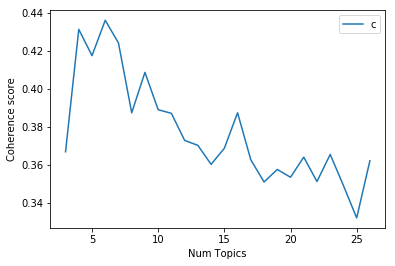

In [16]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
len(model_list)

24

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3667
Num Topics = 4  has Coherence Value of 0.4313
Num Topics = 5  has Coherence Value of 0.4174
Num Topics = 6  has Coherence Value of 0.4361
Num Topics = 7  has Coherence Value of 0.4241
Num Topics = 8  has Coherence Value of 0.3873
Num Topics = 9  has Coherence Value of 0.4086
Num Topics = 10  has Coherence Value of 0.3889
Num Topics = 11  has Coherence Value of 0.387
Num Topics = 12  has Coherence Value of 0.3727
Num Topics = 13  has Coherence Value of 0.3701
Num Topics = 14  has Coherence Value of 0.3601
Num Topics = 15  has Coherence Value of 0.3686
Num Topics = 16  has Coherence Value of 0.3873
Num Topics = 17  has Coherence Value of 0.3625
Num Topics = 18  has Coherence Value of 0.3508
Num Topics = 19  has Coherence Value of 0.3574
Num Topics = 20  has Coherence Value of 0.3533
Num Topics = 21  has Coherence Value of 0.3639
Num Topics = 22  has Coherence Value of 0.3511
Num Topics = 23  has Coherence Value of 0.3654
Num Topics = 24  has 

In [22]:
# Coherence for 4-topic model
coherence_values[1]

0.4312813854758707

In [23]:
# Topics for 4-topic model
malletModel_04 = model_list[1]
model_topics_04 = malletModel_04.show_topics(formatted=False)
pprint(malletModel_04.print_topics(num_words=10))

[(0,
  '0.020*"find" + 0.019*"place" + 0.012*"mile" + 0.010*"large" + 0.009*"begin" '
  '+ 0.009*"small" + 0.008*"hand" + 0.008*"call" + 0.008*"water" + '
  '0.007*"night"'),
 (1,
  '0.032*"day" + 0.025*"man" + 0.025*"work" + 0.016*"thing" + 0.012*"bring" + '
  '0.010*"part" + 0.009*"great" + 0.008*"poor" + 0.007*"time" + '
  '0.007*"winter"'),
 (2,
  '0.035*"make" + 0.031*"good" + 0.027*"year" + 0.016*"country" + 0.015*"live" '
  '+ 0.014*"land" + 0.013*"dollar" + 0.013*"people" + 0.012*"money" + '
  '0.012*"pay"'),
 (3,
  '0.027*"time" + 0.026*"letter" + 0.026*"write" + 0.024*"give" + 0.019*"send" '
  '+ 0.018*"leave" + 0.018*"child" + 0.018*"dear" + 0.015*"hear" + '
  '0.014*"home"')]


In [28]:
# Coherence for 5-topic model
coherence_values[2]

0.4174255633648721

In [29]:
# Topics for 5-topic model
malletModel_05 = model_list[2]
model_topics_05 = malletModel_05.show_topics(formatted=False)
pprint(malletModel_05.print_topics(num_words=10))

[(0,
  '0.043*"good" + 0.034*"year" + 0.023*"great" + 0.021*"make" + '
  '0.020*"country" + 0.019*"thing" + 0.019*"live" + 0.018*"land" + '
  '0.016*"people" + 0.015*"money"'),
 (1,
  '0.040*"day" + 0.032*"man" + 0.031*"work" + 0.024*"make" + 0.023*"send" + '
  '0.022*"child" + 0.022*"dear" + 0.017*"sister" + 0.017*"week" + '
  '0.016*"dollar"'),
 (2,
  '0.033*"letter" + 0.032*"write" + 0.020*"place" + 0.018*"give" + '
  '0.016*"receive" + 0.015*"hear" + 0.015*"family" + 0.011*"arrive" + '
  '0.010*"leave" + 0.009*"answer"'),
 (3,
  '0.041*"time" + 0.024*"long" + 0.016*"feel" + 0.014*"hope" + 0.012*"leave" + '
  '0.012*"begin" + 0.012*"back" + 0.011*"love" + 0.011*"find" + 0.010*"hand"'),
 (4,
  '0.015*"house" + 0.015*"mile" + 0.014*"find" + 0.012*"large" + 0.011*"small" '
  '+ 0.009*"water" + 0.009*"high" + 0.008*"town" + 0.008*"put" + 0.008*"half"')]


In [20]:
# Coherence for 6-topic model
coherence_values[3]

0.43608759047110013

In [21]:
# Topics for 6-topic model
malletModel_06 = model_list[3]
model_topics_06 = malletModel_06.show_topics(formatted=False)
pprint(malletModel_06.print_topics(num_words=10))

[(0,
  '0.029*"find" + 0.028*"place" + 0.019*"house" + 0.018*"mile" + 0.015*"part" '
  '+ 0.014*"large" + 0.013*"small" + 0.012*"water" + 0.011*"high" + '
  '0.010*"town"'),
 (1,
  '0.029*"give" + 0.026*"child" + 0.026*"dear" + 0.023*"leave" + 0.022*"hear" '
  '+ 0.021*"home" + 0.020*"week" + 0.019*"feel" + 0.018*"family" + '
  '0.017*"hope"'),
 (2,
  '0.055*"good" + 0.040*"year" + 0.037*"work" + 0.024*"country" + 0.022*"make" '
  '+ 0.021*"land" + 0.021*"thing" + 0.019*"dollar" + 0.018*"money" + '
  '0.018*"pay"'),
 (3,
  '0.048*"day" + 0.014*"begin" + 0.013*"arrive" + 0.012*"mother" + '
  '0.011*"night" + 0.010*"room" + 0.010*"hour" + 0.010*"morning" + '
  '0.009*"stay" + 0.009*"boy"'),
 (4,
  '0.040*"time" + 0.039*"letter" + 0.039*"write" + 0.029*"send" + 0.024*"long" '
  '+ 0.021*"sister" + 0.019*"receive" + 0.018*"make" + 0.015*"return" + '
  '0.013*"hand"'),
 (5,
  '0.037*"man" + 0.027*"great" + 0.025*"people" + 0.017*"bring" + 0.015*"call" '
  '+ 0.014*"young" + 0.013*"make" + 0

In [26]:
# Coherence for 7-topic model
coherence_values[4]

0.42409284515270035

In [27]:
# Topics for 7-topic model
malletModel_07 = model_list[4]
model_topics_07 = malletModel_07.show_topics(formatted=False)
pprint(malletModel_07.print_topics(num_words=10))

[(0,
  '0.061*"time" + 0.034*"long" + 0.031*"man" + 0.025*"home" + 0.024*"week" + '
  '0.021*"bring" + 0.019*"live" + 0.017*"young" + 0.016*"back" + 0.012*"room"'),
 (1,
  '0.047*"year" + 0.046*"good" + 0.028*"country" + 0.025*"land" + '
  '0.021*"money" + 0.021*"pay" + 0.017*"part" + 0.013*"state" + 0.012*"farm" + '
  '0.011*"person"'),
 (2,
  '0.022*"dollar" + 0.021*"house" + 0.017*"good" + 0.016*"large" + '
  '0.015*"small" + 0.013*"water" + 0.012*"high" + 0.011*"half" + 0.011*"fine" '
  '+ 0.010*"foot"'),
 (3,
  '0.056*"day" + 0.034*"place" + 0.022*"mile" + 0.018*"call" + 0.017*"return" '
  '+ 0.015*"school" + 0.012*"night" + 0.012*"town" + 0.012*"order" + '
  '0.012*"hour"'),
 (4,
  '0.046*"letter" + 0.045*"write" + 0.040*"give" + 0.033*"send" + '
  '0.031*"child" + 0.031*"dear" + 0.026*"hear" + 0.024*"leave" + '
  '0.024*"sister" + 0.022*"receive"'),
 (5,
  '0.064*"make" + 0.045*"work" + 0.036*"find" + 0.028*"thing" + 0.019*"month" '
  '+ 0.017*"begin" + 0.014*"poor" + 0.013*"man

In [24]:
# Coherence for 9-topic model
coherence_values[6]

0.4085936494575172

In [25]:
# Topics for 9-topic model
malletModel_09 = model_list[6]
model_topics_09 = malletModel_09.show_topics(formatted=False)
pprint(malletModel_09.print_topics(num_words=10))

[(0,
  '0.027*"mile" + 0.017*"water" + 0.016*"large" + 0.014*"pass" + 0.013*"stand" '
  '+ 0.013*"find" + 0.013*"foot" + 0.013*"reach" + 0.012*"fall" + 0.012*"end"'),
 (1,
  '0.057*"work" + 0.029*"house" + 0.023*"part" + 0.019*"school" + 0.018*"make" '
  '+ 0.017*"small" + 0.016*"room" + 0.016*"town" + 0.015*"put" + '
  '0.015*"church"'),
 (2,
  '0.056*"give" + 0.029*"thing" + 0.022*"life" + 0.019*"hand" + 0.018*"love" + '
  '0.018*"remain" + 0.016*"bring" + 0.016*"make" + 0.012*"word" + '
  '0.011*"lose"'),
 (3,
  '0.047*"make" + 0.037*"country" + 0.035*"place" + 0.018*"state" + '
  '0.016*"high" + 0.015*"number" + 0.014*"summer" + 0.011*"settle" + '
  '0.011*"hold" + 0.011*"tree"'),
 (4,
  '0.059*"letter" + 0.058*"write" + 0.043*"send" + 0.033*"hear" + 0.028*"feel" '
  '+ 0.028*"receive" + 0.026*"time" + 0.026*"hope" + 0.024*"leave" + '
  '0.019*"arrive"'),
 (5,
  '0.035*"people" + 0.032*"great" + 0.020*"find" + 0.017*"return" + '
  '0.015*"call" + 0.014*"meet" + 0.014*"order" + 0.01

In [30]:
# Convert results to lda model format for visualization.
mallet2ldaModel_06 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(malletModel_06)

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet2ldaModel_06, corpus, id2word)
vis

/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/alaynemoody/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.187993 -0.209419       1        1  16.886327
0     -0.309051 -0.211550       2        1  16.855356
5      0.055885 -0.138777       3        1  16.770017
3     -0.235468  0.236594       4        1  16.529566
1      0.088040  0.250854       5        1  16.502181
4      0.212601  0.072297       6        1  16.456553, topic_info=     Category         Freq       Term        Total  loglift  logprob
78    Default  2596.000000       good  2596.000000  30.0000  30.0000
36    Default  2211.000000        day  2211.000000  29.0000  29.0000
353   Default  1914.000000       year  1914.000000  28.0000  28.0000
215   Default  1817.000000     letter  1817.000000  27.0000  27.0000
23    Default  1799.000000      write  1799.000000  26.0000  26.0000
694   Default  1741.000000        man  1741.000000  25.0000  25.0000
271   Default  1739.000000       work  1739.000000  24.0000  24.0000
45    Default  2394.000000       time  2394.000000  23.0000  23.0000
16    Default  1379.000000       find  1379.000000  22.0000  22.0000
435   Default  1324.000000       send  1324.000000  21.0000  21.0000
324   Default  1339.000000      place  1339.000000  20.0000  20.0000
214   Default  1737.000000       give  1737.000000  19.0000  19.0000
28    Default  1222.000000      child  1222.000000  18.0000  18.0000
725   Default  1219.000000       dear  1219.000000  17.0000  17.0000
17    Default  1318.000000      great  1318.000000  16.0000  16.0000
172   Default  1183.000000     people  1183.000000  15.0000  15.0000
202   Default  1143.000000    country  1143.000000  14.0000  14.0000
422   Default  1021.000000       hear  1021.000000  13.0000  13.0000
70    Default  1008.000000       land  1008.000000  12.0000  12.0000
7     Default  1337.000000       long  1337.000000  11.0000  11.0000
182   Default   975.000000       home   975.000000  10.0000  10.0000
177   Default  2490.000000       make  2490.000000   9.0000   9.0000
222   Default   959.000000     sister   959.000000   8.0000   8.0000
31    Default  1245.000000      leave  1245.000000   7.0000   7.0000
68    Default  1088.000000      thing  1088.000000   6.0000   6.0000
58    Default   942.000000       week   942.000000   5.0000   5.0000
440   Default   902.000000     dollar   902.000000   4.0000   4.0000
37    Default   872.000000       feel   872.000000   3.0000   3.0000
98    Default   870.000000    receive   870.000000   2.0000   2.0000
263   Default   879.000000      house   879.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1056   Topic6   468.060623     expect   468.060623   1.8044  -4.5884
541    Topic6   669.766306     return   672.333770   1.8006  -4.2301
1095   Topic6   449.958831       meet   449.958831   1.8044  -4.6279
183    Topic6   443.493905       read   443.493905   1.8044  -4.6423
808    Topic6   552.104657    present   553.388390   1.8021  -4.4233
308    Topic6   418.927187      speak   418.927187   1.8044  -4.6993
584    Topic6   417.634202       mind   417.634202   1.8044  -4.7024
991    Topic6   364.621811       word   364.621811   1.8044  -4.8382
375    Topic6   345.227034       case   345.227034   1.8044  -4.8928
407    Topic6   333.590168     change   333.590168   1.8044  -4.9271
1522   Topic6   309.023450       book   309.023450   1.8044  -5.0036
417    Topic6   303.851509   continue   303.851509   1.8044  -5.0205
164    Topic6   298.679569       wait   298.679569   1.8044  -5.0377
564    Topic6   285.749717      paper   285.749717   1.8044  -5.0819
196    Topic6   261.182999    trouble   261.182999   1.8044  -5.1718
426    Topic6   243.081207       talk   243.081207   1.8044  -5.2436
1176   Topic6   235.323297     matter   235.323297   1.8044  -5.2761
341    Topic6   234.030311      today   234.030311   1.8044  -5.2816
379    Topic6   231.444341     happen   231.444341   1.8044  -5.2927
517   

Convergence scores are a bit low. Previous research shows that topic modeling on short texts is problematic. One solution is to aggregate the short texts into longer texts. This could be done by author or by letter. 

In [ ]:
# Import metadata 


In [32]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=mallet2ldaModel_06, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

NameError: name 'lda_model' is not defined

In [164]:
map_sentenceText_topicNumber = {}

In [165]:
for index, item in enumerate(data):
    topic_dist = model.get_document_topics(corpus[index])

    # topic_dist is a list of tuples: each tuple has a topic number with its corresponding proportion
    sorted_topic_dist = sorted(topic_dist, key=lambda x: (x[1]), reverse=True) # Sort it in descending order
    
    # Pick the top one:
    topic_number = sorted_topic_dist[0][0]
    map_sentenceText_topicNumber[item] = topic_number

In [166]:
map_sentenceText_topicNumber

{' San Francisco, Jan 29th, 1852.': 0,
 'At last I am at my destination and, if I may be permitted to judge from the impression which the short stay has given me, I shall have reason to congratulate myself upon the choice of my second fatherland.': 3,
 'But before I enter into details about San Francisco — details which will make you burn mid-night oil to read — I beg your indulgence for a brief space while continuing my last description — with the help of my faithful diary — the thread of which you followed to the eleventh day of this month.': 3,
 'The twelfth brought various indications of near-by land, such as the dark-green color of the water, diving ducks (duckers, as the sailors commonly call them), gray birds about the size of our geese.': 1,
 'There also appeared floating alongside of our boat the limb of a tree, covered with leaves, a most convincing and welcome proof that the days of our journey were numbered.': 2,
 'At about a quarter to one, the same afternoon, the joyous s

In [168]:
df['topicNumber'] = df['Sentence'].map(map_sentenceText_topicNumber)

In [169]:
df

,Unnamed: 0,Sentence,fileid,Sentiment,topicNumber
0,0,"San Francisco, Jan 29th, 1852.",S8552-D007.txt,0.0000,0
1,1,"At last I am at my destination and, if I may b...",S8552-D007.txt,0.6249,3
2,2,But before I enter into details about San Fran...,S8552-D007.txt,0.6808,3
3,3,The twelfth brought various indications of nea...,S8552-D007.txt,0.0772,1
4,4,There also appeared floating alongside of our ...,S8552-D007.txt,0.7397,2
5,5,"At about a quarter to one, the same afternoon,...",S8552-D007.txt,0.7096,1
6,6,Soon after we commenced to notice the outlines...,S8552-D007.txt,0.0000,4
7,7,The sea grew calmer and the air warmer.,S8552-D007.txt,0.5719,2
8,8,"As darkness set in we, of course, lost sight o...",S8552-D007.txt,-0.5106,0
9,9,By four o'clock the next morning we found ours...,S8552-D007.txt,0.8479,2


In [170]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4386,"make, day, work, place, house, money, man, beg...",I could fill this letter with names and lives ...
1,1.0,0.5987,"good, find, dollar, mile, land, year, bring, p...","For your amusement, here's a typical week's me..."
2,2.0,0.5365,"long, city, part, large, small, water, foot, h...","Oatmeal, Indian meal, and rice, when boiled as..."
3,3.0,0.5040,"time, give, letter, write, send, home, leave, ...",The generality of Irishmen who swarm in and ab...
4,4.0,0.5114,"man, people, great, year, child, life, country...","The cause of most of the crime, poverty, idlen..."


In [196]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

0.0    22196
3.0    17160
1.0    16449
2.0    13793
4.0    13332
Name: Dominant_Topic, dtype: int64

In [203]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

0.0    0.2676
3.0    0.2069
1.0    0.1983
2.0    0.1663
4.0    0.1608
Name: Dominant_Topic, dtype: float64

In [214]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by = 'Dominant_Topic')
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,1.0,"good, find, dollar, mile, land, year, bring, p..."
4,2.0,"long, city, part, large, small, water, foot, h..."
1,3.0,"time, give, letter, write, send, home, leave, ..."
6,4.0,"man, people, great, year, child, life, country..."


In [215]:
topic_num_keywords.reset_index(drop=True, inplace=True)
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
4,4.0,"man, people, great, year, child, life, country..."


In [216]:
topic_num_keywords = topic_num_keywords.reindex([0,3,1,2,4])
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
4,4.0,"man, people, great, year, child, life, country..."


In [227]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.rename('counts'), topic_contribution.rename('contribution')], axis=1).sort_values(by = 'Dominant_Topic')
df_dominant_topics

,Dominant_Topic,Topic_Keywords,counts,contribution
0,0.0,"make, day, work, place, house, money, man, beg...",22196,0.2676
1,1.0,"good, find, dollar, mile, land, year, bring, p...",16449,0.1983
2,2.0,"long, city, part, large, small, water, foot, h...",13793,0.1663
3,3.0,"time, give, letter, write, send, home, leave, ...",17160,0.2069
4,4.0,"man, people, great, year, child, life, country...",13332,0.1608
